# Manifold Learning

While PCA is flexible, fast, and interpretable, __it does not perform well when data contains nonlinear relationships.

We can use __manifold learning__ to address these types of problems. Manifolds are a class of unsupervised estimators that describes datasets as low-dimensional manifolds embedded in high-dimensional spaces.

__Imagine a manifold as a sheet of paper__: a two-dimensional object that lives in a three-dimensional world. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.

Typical manifold techniques include __multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap)__.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Manifold Learning: "HELLO"

Here is a function that creates & saves a dataset in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

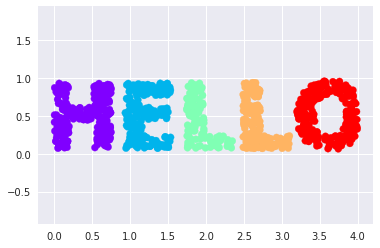

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

### Multidimensional Scaling (MDS)

The *x* and *y* values of the dataset are not the best description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.

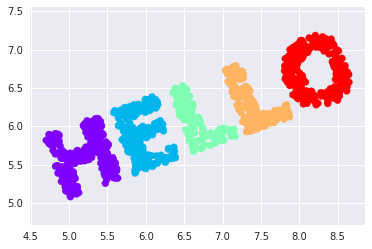

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

What *is* fundamental, in this case, __is the *distance* between each point and the other points in the dataset__. A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.

Use Scikit's ``pairwise_distances`` function to build a distance matrix.

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

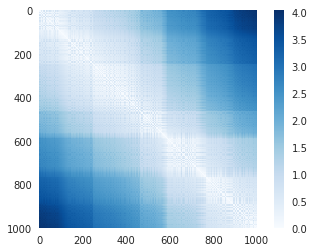

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

If we build a distance matrix from the rotated/translated data, __we see that it matches the original.__

In [9]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

The distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization is not that useful. __For example, we lost any trace of the most interesting structure in the data: the "HELLO"__.

Further, while computing the distance matrix is straightforward, transforming the distances back into *x* and *y* coordinates is difficult. __This is exactly what the multidimensional scaling algorithm solves: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.__

Let's see how this works. Use the ``precomputed`` dissimilarity to specify that we are passing a distance matrix.

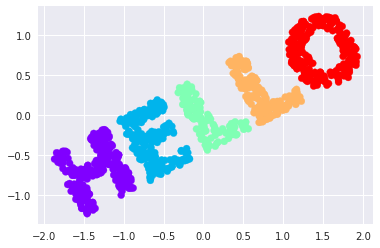

In [10]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

MDS recovered one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points. Cool!

### MDS as Manifold Learning

The value of this becomes more apparent when we realize that distance matrices can be computed from data in *any* dimension.

Instead of simply rotating the data in the two-dimensional plane, __we can project it into three dimensions__ using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [11]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

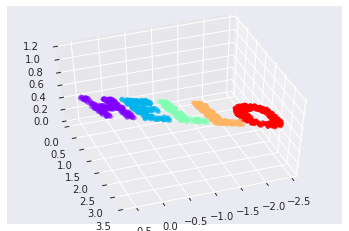

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

Ask the ``MDS`` estimator to read this three-dimensional data, find the distance matrix, then find the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

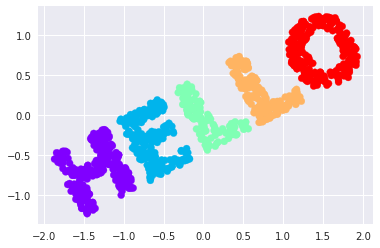

In [13]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is the purpose of a manifold learning estimator. Given high-dimensional embedded data, it finds a low-dimensional representation of the data that preserves certain relationships within the data. __In the case of MDS, the quantity preserved is the distance between every pair of points.__

### Nonlinear Embeddings: Where MDS Fails

MDS can handle *linear* embeddings (rotations, translations, and scalings into higher-dimensional spaces), but falters when the embedding is nonlinear. Consider the example where the data is changed into an "S" shape in three dimensions:

In [14]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

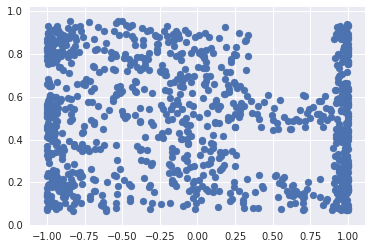

In [16]:
ax = plt.axes()
ax.scatter(XS[:, 0], XS[:, 1])

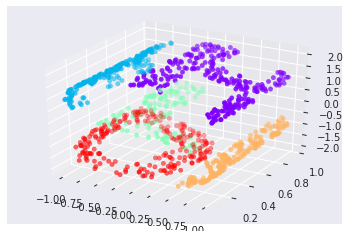

In [15]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

MDS is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold.

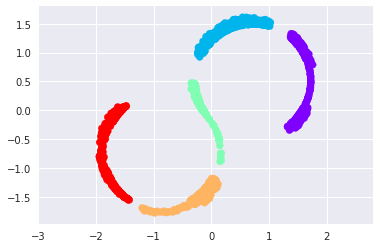

In [17]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

### Nonlinear Manifolds: Locally Linear Embedding

The problem is that __MDS tries to preserve distances between faraway points when constructing the embedding.__ What if we modified the algorithm such that __it only preserves distances between nearby points?__

![(LLE vs MDS linkages)](05.10-LLE-vs-MDS.png)

Each faint line represents a distance that __should be preserved__ in the embedding.

On the left is the MDS representation of the data: it tries to preserve the distances between each pair of points.

On the right is a representation of the model using __locally linear embedding (LLE)__. Instead of preserving *all* distances, it tries to preserve only the distances between *neighboring points*. (In this case, the nearest 100 neighbors of each point.)

We can see why MDS fails: there's no way to flatten the data while adequately preserving the length of every line drawn between the two points. The LLE plot looks a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same. This is precisely what LLE does, through a __global optimization of a cost function__ reflecting this goal.

LLE has several options; let's use the __modified LLE__ algorithm to recover the embedded two-dimensional manifold. Modified LLE usually does better at recovering well-defined manifolds with very little distortion:

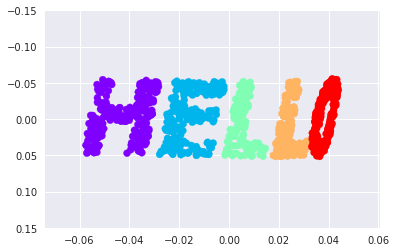

In [18]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

### Manifold Method Tradeoffs

Manifold learning techniques tend to be finicky. They are rarely used for anything more than visualization of high-dimensional data.

__Disadvantages vs PCA__:

- There is no good framework for handling missing data.
- Noise in the data can "short-circuit" the manifold and drastically change the embedding. PCA naturally filters noise from the most important components.
- Results are highly dependent on the number of neighbors chosen. There's no solid quantitative way to choose an optimal number of neighbors. PCA does not involve such a choice.
- The optimal number of output dimensions is difficult to determine. PCA lets you find the output dimension based on the explained variance.
- The meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
- Manifold computations scale as O[N^2] or O[N^3]. For PCA, some randomized approaches that are much faster. See the [megaman](https://github.com/mmp2/megaman) package for some more scalable implementations of manifold learning.


__Advatanges over PCA__:

- Their ability to preserve nonlinear relationships. Consider using manifolds only after trying PCA first.

- See the Scikit docs for a [nice discussion and comparison of manifold technques](http://scikit-learn.org/stable/modules/manifold.html).


- __Recommendations__:

- For toy problems such as the S-curve, locally linear embedding (LLE) and its variants (especially *modified LLE*), perform very well.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) can lead to more meaningful embeddings.
- For highly clustered data, __t-distributed stochastic neighbor embedding (t-SNE)__ seems to work very well, though can be very slow.

### Example: Isomap on Faces

Manifold learning is often used to understand the relationship between high-dimensional data points such as images. Images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Let's apply Isomap on the Labeled Faces in the Wild dataset.

In [19]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images with 2,914 pixels each. Let's view a few of them.

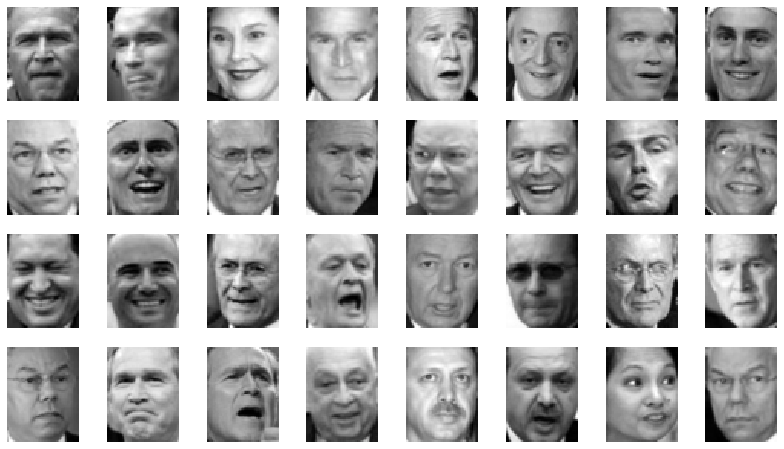

In [21]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]), figsize=(14,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Plot a low-dimensional embedding of the 2,914-dimensional data to learn the relationships between the images.
__Start with PCA__ and view the explained variance ratio. This will tell us roughly how many linear features are required to describe the data.

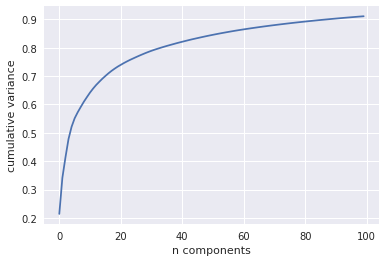

In [22]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Hmmm. Nearly 100 components are required to preserve 90% of the variance. This tells us that the data is intrinsically very high dimensional—__it can't be described linearly with just a few components.__

In this case __nonlinear manifold embeddings like LLE and Isomap can be helpful__. Let's try __an Isomap embedding__ on these faces.

In [23]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images. Let's define a function that outputs image thumbnails at the locations of the projections:

In [24]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

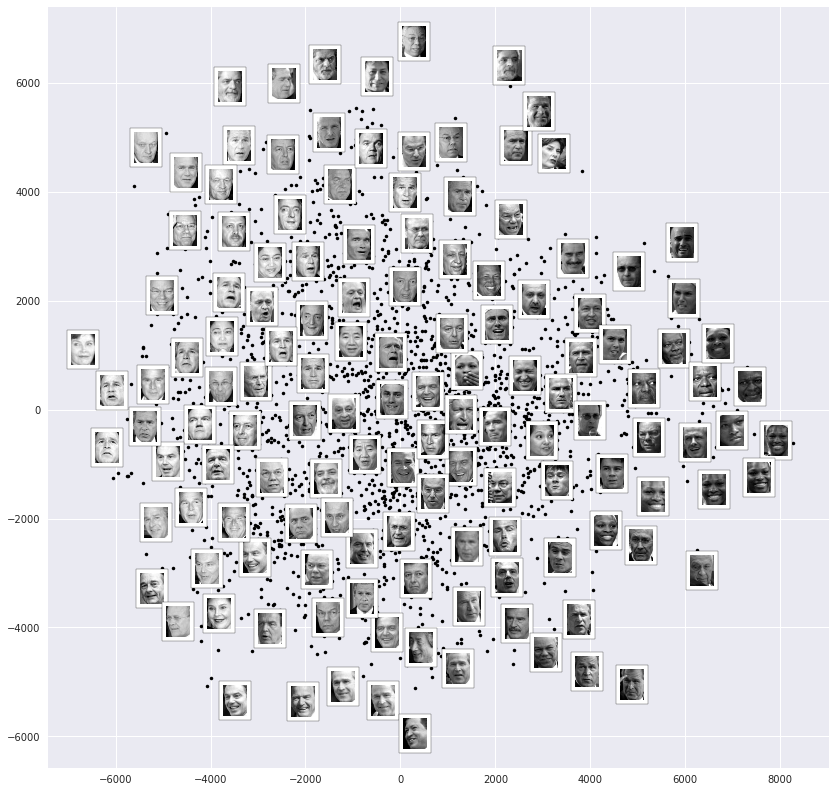

In [26]:
fig, ax = plt.subplots(figsize=(14,14))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The first two Isomap dimensions seem to describe __global image features (overall darkness or lightness of the image from left to right__, and the __general orientation of the face from bottom to top.__) This gives a nice visual indication of some of the fundamental features in our data.

### Example: Visualizing Structure in Digits

Let's apply manifold learning to the MNIST handwritten digits set. The dataset contains 70,000 images with 784 pixels each (i.e. the images are 28×28).

In [27]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="mldata")

In [28]:
mnist.data.shape

(70000, 784)

View the first few images:

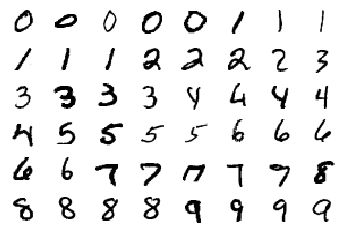

In [29]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

__Build a manifold learning projection__ across the data. Use only 1/30 of the data, which is about ~2000 points, for speed. (Manifold learning scales rather poorly.)

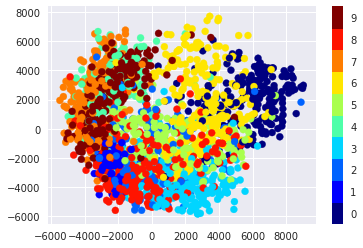

In [30]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The scatter plot shows some relationships, but is a bit crowded. Try looking at just the "1" digit.

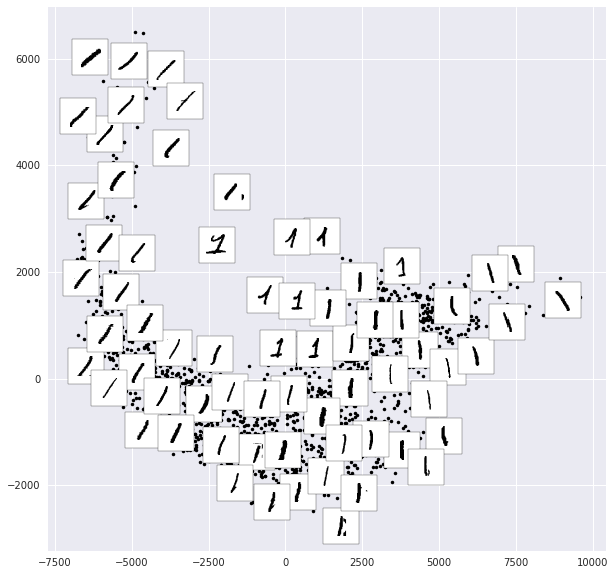

In [31]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

This hints at the variety of forms that the number "1" can take within the dataset. 

This may not be useful for classifying digits, but it does help visualize the data and ideas on how to proceed - including a preprocess strategy before building a classification pipeline.